In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis
['/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles/lib/python', '/home/admin-u6015325/anaconda3/lib/python37.zip', '/home/admin-u6015325/anaconda3/lib/python3.7', '/home/admin-u6015325/anaconda3/lib/python3.7/lib-dynload', '', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/strkernel-0.2-py3.7.egg', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/admin-u6015325/.ipython', '/home/admin-u6015325/ownCloud/git/SynbioML']


# Plot setting

In [107]:
# rcParams['axes.labelsize'] = 10
# rcParams['xtick.labelsize'] = 10
# rcParams['ytick.labelsize'] = 10
# rcParams['legend.fontsize'] = 10
# rcParams['font.family'] = 'serif'
# rcParams['font.serif'] = ['Computer Modern Roman']
# rcParams['text.usetex'] = True

# set color
color_dict = {}

viridis = cm.get_cmap('viridis', 5)
tab10 = cm.get_cmap('tab10', 10)

color_dict['Consensus'] = tab10.colors[1]
color_dict['Reference'] = tab10.colors[3]
color_dict['BPS-C'] = tab10.colors[5]
color_dict['BPS-NC'] = tab10.colors[6]
color_dict['UNI'] = tab10.colors[7]
color_dict['PPM'] = tab10.colors[8]
color_dict['Bandit-0'] = viridis.colors[0]
color_dict['Bandit-1'] = viridis.colors[1]
color_dict['Bandit-2'] = viridis.colors[2]
color_dict['Bandit-3'] = viridis.colors[3]
color_dict['Unlabeled'] = tab10.colors[7]
color_dict['Random'] = tab10.colors[8]

sns.set_palette(list(color_dict.values())[1:])

# generate valids names and path for plots

def valid_name(name):
    return name.replace('_', ' ')  
def valid_path(path):
    return path.replace(' ', '_')

folder_path = '../../data/pipeline_data/'
plot_path = '../../notebooks/paper_plots/'

In [11]:
plot_swarm_flag = False
plot_quant_flag = False
plot_scatter_flag = False
plot_tsne_flag = True
gene_rec_flag = False

# Read data

Define the following steps on each replicate:  
- A. In each round, substract the mean of every data points by the reference AVERAGE, and then add 100 (to make the values positive).  
- B. Take log (base e) transformation for each data points.  
- C. Apply z-score normalisation.  
    - C.1 on all data, so that the mean and variance of each replicate of all data is zero and one after normalisation. 
    - C.2 on each round, so that the mean and variance of each replicate of data in each round is zero and one after normalisation. 
- D. Apply min-max normalisation.
    - D.1 on all data
    - D.2 on each round
- E. Apply ratio normalisation. In each round, each data points is devided by the mean of refernce AVERAGE, so that in each round, the reference labels are almost 1. 

In [4]:
# read data

df_e1 = pd.read_csv(folder_path + 'Results_e1.csv')
df_abc2 = pd.read_csv(folder_path + 'Results_abc2.csv')
df_abc1 = pd.read_csv(folder_path + 'Results_abc1.csv')

In [67]:
df_e1['Group2'] = df_e1['Group']
df_e1.loc[df_e1['Group2'] == 'UNI', 'Group2'] = 'Random'
df_e1.loc[df_e1['Group2'] == 'PPM', 'Group2'] = 'Random'

if plot_quant_flag:
    sns.set_palette('viridis') 
    quant_line(df_e1, 'Group2')
    

# TSNE plot

In [7]:
n_dim = 2

wds_kernel = WD_Shift_Kernel(l = 6, s=1)
distance = wds_kernel.distance(wds_kernel.kernel_all_normalised)

wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...


/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


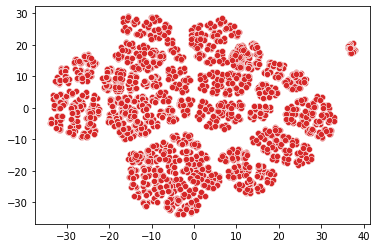

In [8]:

# dim reduction
tsne = TSNE(n_components = n_dim, metric = 'precomputed')
tsne_distance = tsne.fit_transform(distance)

In [139]:
with open('../../data/idx_seq.pickle', 'rb') as handle:
    idx_seq_dict = pickle.load(handle)['idx_seq_dict']

group_dict = defaultdict(list)
group_TIR_dict = defaultdict(list)
known_seq = set(df_e1['RBS'])
size = 120

for idx in range(distance.shape[0]):
    seq = idx_seq_dict[idx]
    if seq in known_seq:
        group = df_e1.loc[df_e1['RBS'] == seq, 'Group2'].values[0]
        TIR = df_e1.loc[df_e1['RBS'] == seq, 'AVERAGE'].values[0]
        # print(group)
        group_dict[group].append(idx)
        group_TIR_dict[group].append(TIR * size)
        # idx_color_dict[idx] = color_dict[str(group)]
        # color_list.append(color_dict[str(group)])
    else:
        group_dict['Unlabeled'].append(idx)
        group_TIR_dict['Unlabeled'].append(0.2 * size)


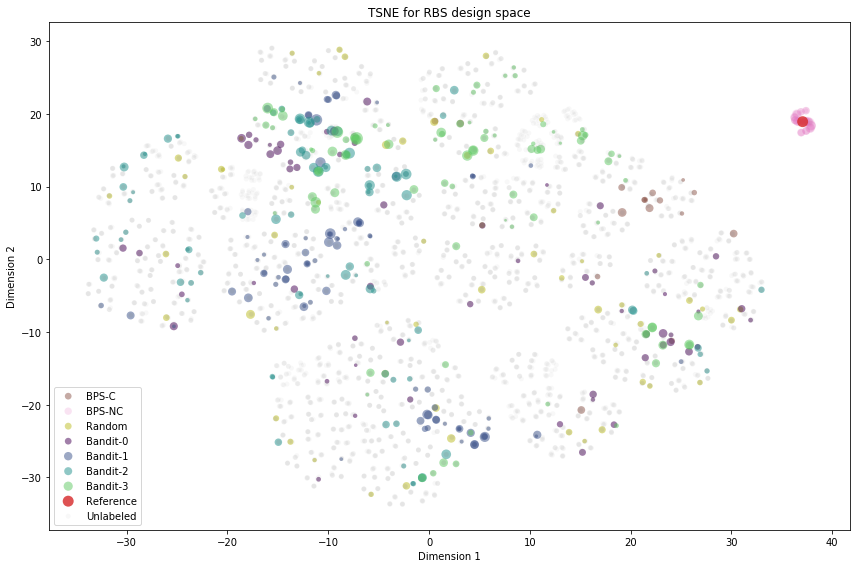

In [142]:
if plot_tsne_flag:
    f, axes = plt.subplots(1, 1, figsize=(12, 8), sharex=False)
    groups = ['BPS-C', 'BPS-NC', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3', 'Reference', 'Unlabeled']
    for group in groups:
        idxes = np.asarray(group_dict[group])
        if group == 'Unlabeled':
            alpha = 0.05
        elif group == 'BPS-NC':
            alpha = 0.2
        elif group == 'Reference':
            alpha = 0.8
        else:
            alpha = 0.5
      
        plt.scatter(tsne_distance[idxes,0], tsne_distance[idxes,1], alpha = alpha, color = color_dict[group], edgecolors = 'none', s = group_TIR_dict[group][:], label = group)
        plt.legend(loc = 'lower left')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.title('TSNE for RBS design space')
        plt.tight_layout()
        plt.savefig(plot_path +'tsneplot.pdf')

# Swarmplot

In [5]:
if plot_swarm_flag:
    f, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=False)
    sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_e1, ax = axes, order=['Reference', 'BPS-NC', 'BPS-C', 'UNI', 'PPM', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])
    y = df_e1[df_e1['Group'] == 'Consensus']['AVERAGE']
    axes.scatter(x = 0, y = y, color = color_dict['consensus'])
    axes.text(0, y + 0.05, 'SD')
    axes.set(xlabel='Sequence design principles', ylabel='Translation Initiation Rate (TIR),\\ averaged over 6 technical replicates')
    axes.set_title('Swarmplot with TIR Labels (ratio)')
    plt.tight_layout()
    plt.savefig(plot_path + 'swarmplot.pdf')

# Quantile plot

In [6]:

def quant_line(df, col = 'Group', title = 'Quantile of groups'):
    f, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=False)
    quantile_levels = [0.9, 0.8, 0.7, 0.6, 0.5]
    used_groups = ['BPS-C', 'Random', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3']
    df_bandits = df.loc[df[col].isin(used_groups)]

    quant_dict = defaultdict(list)
    groups = df_bandits.groupby(col)
    

    for used_group in used_groups:
        quant_dict['max'].append(groups.get_group(used_group)['AVERAGE'].max())
    axes.plot(range(len(used_groups)), quant_dict['max'], marker = '.', label = 'max', alpha = 0.8, color = 'orange')

    for quant in quantile_levels:
        for used_group in used_groups:
            quant_dict[quant].append(groups.get_group(used_group)['AVERAGE'].quantile(quant))
        axes.plot(range(len(used_groups)), quant_dict[quant], marker = '.', label = str(quant), alpha = 0.8)
 
    # plt.plot(df_bandits.sort_values('AVERAGE',ascending=False).groupby(col).nth(4)['AVERAGE'], marker = '.', label = 'Top-5', alpha = 0.6)
    plt.legend()
    plt.xticks(range(len(used_groups)), used_groups)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(plot_path + 'quantplot.pdf')

# Scatterplot

In [8]:
# copy from the pipeline for recommending round 2 seq
from codes.batch_ucb import *
from codes.regression import *
from scipy.stats import spearmanr

rec_size = 90
l = 6
s = 1
beta = 0
alpha = 2
sigma_0 = 1
kernel = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True

sns.set_palette('tab10') 

In [9]:
def run_regression(df,kernel, embedding, predictor = GPR_Predictor, train_idx = None, test_idx = None, 
                    eva_metric = [mean_squared_error, r2_score], l = 6, s = 1, sigma_0=1, alpha = 2, 
                    eva_on='seqs', title = 'Prediction',
                    kernel_norm_flag = True, centering_flag = False, unit_norm_flag = True):
    title = title + ' centering' + str(centering_flag) + 'unitnorm' + str(unit_norm_flag)
    # train and test on round 0
    gpr_train_samples = predictor(df, train_idx= train_idx, test_idx=test_idx, kernel_name = kernel,
                kernel_norm_flag = kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag = unit_norm_flag,
                embedding = embedding, eva_metric = eva_metric, l = l, s = s, sigma_0 = sigma_0, alpha = alpha, eva_on=eva_on)
    gpr_train_samples.regression(random_state = 0)

    return gpr_train_samples
    # gpr_train_samples.scatter_plot(title = title)

In [10]:
def scatter_plot(predictor_list, title, plot_title = 'Prediction'):
        """Scatter plot for predictions.
        x-axis: label
        y-axis: prediction
        """
        fig, axes = plt.subplots(1,4, figsize = (20,6))
        for i, predictor in enumerate(predictor_list):
            if predictor.eva_on == 'samples':
                eva_column = 'label'
            else:
                eva_column = 'AVERAGE'

            # if eva_column == 'AVERAGE': # debug
            #     self.train_df = self.train_df[self.train_df['variable'] == 'Rep1']
            print('#################################')
            print('  Evaluation  ', title[i])
            print('#################################')
            for metric in predictor.eva_metric:
                print(str(metric))
                print('Train: ', metric(predictor.train_df[eva_column], predictor.train_df['pred mean']))
                print('Test: ', metric(predictor.test_df[eva_column], predictor.test_df['pred mean']))

            print('spearman cor:')
            print('Train: ', spearmanr(predictor.train_df[eva_column], predictor.train_df['pred mean']))
            test_spearmanr = spearmanr(predictor.test_df[eva_column], predictor.test_df['pred mean'])
            print('Test: ', test_spearmanr.correlation, ' ', test_spearmanr.pvalue)

            # report slope
            test_pred_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['pred mean'],deg=1)
            test_ave_fit = np.polyfit(x = range(len(predictor.test_df)), y=predictor.test_df.sort_values(by = ['AVERAGE'])['AVERAGE'],deg=1)
            print('Test pred fit: ', test_pred_fit)
            print('Test ave fit: ', test_ave_fit)
            
            if 'pred std' in predictor.test_df:
                print('coverage rate: ')
                print('Train: ',  predictor.coverage_rate(predictor.train_df[eva_column], predictor.train_df['pred mean'], predictor.train_df['pred std']))
                print('Test: ',  predictor.coverage_rate(predictor.test_df[eva_column], predictor.test_df['pred mean'], predictor.test_df['pred std']))

            axes[i].scatter(predictor.train_df[eva_column], predictor.train_df['pred mean'], label = 'train', alpha = 0.2)
            axes[i].scatter(predictor.test_df[eva_column], predictor.test_df['pred mean'], label = 'test', alpha = 0.8)
            axes[i].set_xlabel('True TIR')
            axes[i].set_ylabel('Predict TIR')
            axes[i].legend()
            axes[i].plot([-2, 3], [-2,3], '--', color = 'black', alpha = 0.5)
            axes[i].set_title('\n' + title[i] + 
                ' R2 = ' + str("{:.3f}".format(r2_score(predictor.test_df[eva_column], predictor.test_df['pred mean']))) + 
                '\n Spearman cor = ' + str("{:.3f}".format(test_spearmanr.correlation)) + ' pvalue: ' + str("{:.2e}".format(test_spearmanr.pvalue))
                )

        fig.suptitle(plot_title, size = 16, y = 0.98)
        fig.tight_layout()
        fig.subplots_adjust(top=0.85)
        fig.savefig(plot_path + 'scatter_' + valid_path(plot_title) + '.pdf')

In [11]:
def generate_predictors(df, kernel, embedding, kernel_norm_flag = True, centering_flag = True, unit_norm_flag = True):
    predictors = []
    for i in range(1,4):
        title = 'Train < ' + str(i)+ ' and Test ' + str(i)
        predictor = run_regression(df, kernel, embedding, train_idx = df['Round'] < i, test_idx = df['Round'] == i, title = title, centering_flag=centering_flag, unit_norm_flag=unit_norm_flag)
        predictors.append(predictor)

    predictor = run_regression(df, kernel, embedding, title = 'Train and Test on All Rounds', centering_flag=centering_flag, unit_norm_flag=unit_norm_flag)
    predictors.append(predictor)
    return predictors
    

In [13]:
if plot_scatter_flag:
    centering_flag = True
    unit_norm_flag = True
    df_abc1_TT_predictors = generate_predictors(df_abc1, kernel, embedding, centering_flag, unit_norm_flag)

In [15]:
if plot_scatter_flag:
    scatter_plot(df_abc1_TT_predictors, ['train 0 test 1', 'train 01 test 2', 'train 012 test 3', 'train test all'], 'abc1 TT')

In [16]:
if plot_scatter_flag:
    centering_flag = False
    unit_norm_flag = False

    df_abc1_FF_predictors = generate_predictors(df_abc1, kernel, embedding, centering_flag, unit_norm_flag)

In [17]:
if plot_scatter_flag:
    scatter_plot(df_abc1_FF_predictors, 
                ['train 0 test 1', 'train 01 test 2', 'train 012 test 3', 'train test all'], 'abc1 FF')

In [18]:
if plot_scatter_flag:
    centering_flag = True
    unit_norm_flag = True
    df_abc2_TT_predictors = generate_predictors(df_abc2, kernel, embedding, centering_flag, unit_norm_flag)

In [19]:
if plot_scatter_flag:
    scatter_plot(df_abc2_TT_predictors, ['train 0 test 1', 'train 01 test 2', 'train 012 test 3', 'train test all'], 'abc2 TT')

In [20]:
if plot_scatter_flag:
    centering_flag = False
    unit_norm_flag = False
    df_abc2_FF_predictors = generate_predictors(df_abc2, kernel, embedding, centering_flag, unit_norm_flag)

In [21]:
if plot_scatter_flag:
    scatter_plot(df_abc2_FF_predictors, ['train 0 test 1', 'train 01 test 2', 'train 012 test 3', 'train test all'], 'abc2 FF')

# Confirm rec 

In [34]:
from codes.batch_ucb import *

centering_flag = False
unit_norm_flag = True
rec_size = 90
beta = 2

rec_dict = {}

In [35]:

if gene_rec_flag:
    for i in [1,2,3]:
        if i == 3:
            beta = 0

        top_n = Top_n_ucb(df_abc1[df_abc1['Round'] < i], kernel_name=kernel, l=l, s=s, sigma_0=sigma_0,
                        embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
                        kernel_norm_flag=kernel_norm_flag, centering_flag = centering_flag,              unit_norm_flag=unit_norm_flag)

        top_n_rec_df = top_n.run_experiment()
        rec_dict[i] = top_n_rec_df

    for i, df in rec_dict.items():
        new_rec = set(np.asarray(df['RBS6']))
        lib_rec = set(np.asarray(df_abc1[df_abc1['Round'] == i]['RBS6']))
        num_overlap = len(new_rec.intersection(lib_rec))
        print(i)
        print(num_overlap)

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'


X train shape:  (1055, 20)
X test shape:  (3961, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg


/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'


X train shape:  (1589, 20)
X test shape:  (3873, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg


/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'


X train shape:  (2147, 20)
X test shape:  (3783, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_False_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg


In [32]:
centering_flag = True
unit_norm_flag = True
rec_size = 90
beta = 2

abc1TT_rec_dict = {}

if gene_rec_flag:
    for i in [1,2,3]:
        if i == 3:
            beta = 0

        top_n = Top_n_ucb(df_abc1[df_abc1['Round'] < i], kernel_name=kernel, l=l, s=s, sigma_0=sigma_0,
                        embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
                        kernel_norm_flag=kernel_norm_flag, centering_flag = centering_flag,              unit_norm_flag=unit_norm_flag)

        top_n_rec_df = top_n.run_experiment()
        abc1TT_rec_dict[i] = top_n_rec_df

    for i, df in abc1TT_rec_dict.items():
        new_rec = set(np.asarray(df['RBS6']))
        lib_rec = set(np.asarray(df_abc1[df_abc1['Round'] == i]['RBS6']))
        num_overlap = len(new_rec.intersection(lib_rec))
        print(i)
        print(num_overlap)

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'


X train shape:  (1055, 20)
X test shape:  (3961, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg


/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'


X train shape:  (1589, 20)
X test shape:  (3873, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg


/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'


X train shape:  (2147, 20)
X test shape:  (3783, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
